# Gun Violence Archive: Deadly mass shooting locations

### Import Python tools and Jupyter configuration

In [1]:
%load_ext lab_black

In [49]:
import pandas as pd
import geopandas as gpd
import altair as alt
import datetime as dt
import numpy as np
import altair as alt
import altair_stiles as altstiles
import requests
from bs4 import BeautifulSoup
import us

In [3]:
alt.themes.register("stiles", altstiles.theme)
alt.themes.enable("stiles")

ThemeRegistry.enable('grid')

In [4]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = None

In [5]:
today = dt.date.today().strftime("%Y-%m-%d")

---

In [6]:
address_src = (
    pd.read_csv(
        "../geocoder/data/output/mass_shootings_involving_deaths_addresses.csv",
        dtype={"postcode": str},
    )
    .drop(
        [
            "Unnamed: 0",
            "google_place_id",
            "number_of_results",
            "google_place_id",
            "response",
            "status",
            "type",
        ],
        axis=1,
    )
    .drop_duplicates(keep="last")
)

In [7]:
address_src.head()

,formatted_address,latitude,longitude,accuracy,postcode,input_string
0,"6161 S Yale Ave, Tulsa, OK 74136, USA",36.070540,-95.918287,ROOFTOP,74136,"6161 S Yale Ave, Tulsa, OK"
1,"999 Pipestone St, Benton Harbor, MI 49022, USA",42.100016,-86.437591,ROOFTOP,49022,"999 Pipestone St, Benton Harbor, MI"
2,"E Tioga St & N Delaware Ave, Philadelphia, PA 19134, USA",39.980463,-75.088958,GEOMETRIC_CENTER,19134,"N Delaware Ave and E Tioga St, Philadelphia, PA"
3,"W Windsor Ave & N 58th Ave, Phoenix, AZ 85035, USA",33.477698,-112.183885,GEOMETRIC_CENTER,85035,"N 58th St and W Windsor Ave, Phoenix, AZ"
4,"104 Elm St, Taft, OK 74463, USA",35.761003,-95.545917,ROOFTOP,74463,"104 Elm St, Taft, OK"


In [8]:
len(address_src)

2064

In [9]:
incident_src = (
    pd.read_csv(
        "data/processed/mass_shootings_involving_deaths.csv",
        dtype={"incident_id": str},
        parse_dates=["incident_date"],
    )
    .drop(
        [
            "address",
            "state",
        ],
        axis=1,
    )
    .drop_duplicates(subset="incident_id", keep="last")
)

In [10]:
incident_src.head()

,incident_id,incident_date,city_or_county,no_killed,no_injured,total,year,ap_state,postal_state,full_address
0,2318310,2022-06-01,Tulsa,5,0,5,2022,Okla.,OK,"6161 S Yale Ave, Tulsa, OK"
1,2316616,2022-05-30,Benton Harbor,1,6,7,2022,Mich.,MI,"999 Pipestone St, Benton Harbor, MI"
2,2315903,2022-05-30,Philadelphia,2,2,4,2022,Pa.,PA,"N Delaware Ave and E Tioga St, Philadelphia, PA"
3,2315150,2022-05-29,Taft,1,7,8,2022,Okla.,OK,"104 Elm St, Taft, OK"
4,2315605,2022-05-29,Phoenix,1,5,6,2022,Ariz.,AZ,"N 58th St and W Windsor Ave, Phoenix, AZ"


In [11]:
len(incident_src)

2070

#### Merge them

In [12]:
src = (
    pd.merge(
        incident_src,
        address_src,
        left_on="full_address",
        right_on="input_string",
        how="inner",
    )
    .drop_duplicates()
    .drop(
        [
            "input_string",
            "full_address",
        ],
        axis=1,
    )
)

In [13]:
len(src)

2070

In [14]:
src.head()

,incident_id,incident_date,city_or_county,no_killed,no_injured,total,year,ap_state,postal_state,formatted_address,latitude,longitude,accuracy,postcode
0,2318310,2022-06-01,Tulsa,5,0,5,2022,Okla.,OK,"6161 S Yale Ave, Tulsa, OK 74136, USA",36.070540,-95.918287,ROOFTOP,74136
1,2316616,2022-05-30,Benton Harbor,1,6,7,2022,Mich.,MI,"999 Pipestone St, Benton Harbor, MI 49022, USA",42.100016,-86.437591,ROOFTOP,49022
2,2315903,2022-05-30,Philadelphia,2,2,4,2022,Pa.,PA,"E Tioga St & N Delaware Ave, Philadelphia, PA 19134, USA",39.980463,-75.088958,GEOMETRIC_CENTER,19134
3,2315150,2022-05-29,Taft,1,7,8,2022,Okla.,OK,"104 Elm St, Taft, OK 74463, USA",35.761003,-95.545917,ROOFTOP,74463
4,2315605,2022-05-29,Phoenix,1,5,6,2022,Ariz.,AZ,"W Windsor Ave & N 58th Ave, Phoenix, AZ 85035, USA",33.477698,-112.183885,GEOMETRIC_CENTER,85035


<!-- #### Just incidents where at least three people died -->

In [15]:
# df = src[src["no_killed"] >= 3].copy()

In [16]:
df = src.copy()

----

## Aggregate

#### States

In [44]:
states_grouped = (
    df.groupby(["ap_state"])
    .agg(
        {
            "no_killed": "sum",
            "no_injured": "sum",
            "total": "sum",
        }
    )
    .reset_index()
)

In [50]:
states_grouped.head()

,ap_state,no_killed,no_injured,total
0,Ala.,98,185,283
1,Alaska,6,8,14
2,Ariz.,69,108,177
3,Ark.,41,114,155
4,Calif.,444,755,1199


In [46]:
states = pd.read_csv("data/raw/states_population.csv")

In [51]:
name_to_ap = us.states.mapping("name", "ap_abbr")

In [52]:
states["ap_state"] = states["state"].map(name_to_ap)

In [80]:
state_grouped_pop = pd.merge(states_grouped, states, on="ap_state")

In [81]:
state_grouped_pop["rate_per_one_million"] = (
    (state_grouped_pop["no_killed"] / state_grouped_pop["population"]) * 1000000
).round()

In [82]:
state_grouped_pop = state_grouped_pop.sort_values(
    "rate_per_one_million", ascending=False
)

In [83]:
len(state_grouped_pop)

46

#### 2020 results

In [84]:
election = pd.read_csv("data/processed/2020_election_results_states.csv")

In [87]:
states_grouped_elex = pd.merge(
    state_grouped_pop,
    election[["winner", "state_name"]],
    left_on="state",
    right_on="state_name",
)

In [89]:
states_grouped_elex.head(25)

In [90]:
states_grouped_elex.to_csv(
    "data/processed/mass_shootings_rates_states_elex.csv", index=False
)

---

## Geography

#### Convert shootings database into geodataframe from lon, lat

In [17]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

<AxesSubplot:>

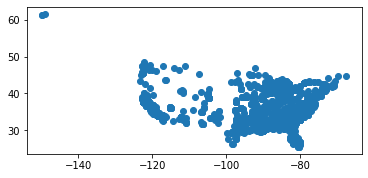

In [18]:
gdf.plot()

In [19]:
gdf = gdf.set_crs("EPSG:4326")

#### Import congressional districts

In [20]:
cd_gdf = gpd.read_file("data/raw/congress.geojson")

<AxesSubplot:>

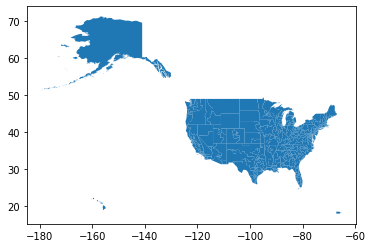

In [21]:
cd_gdf.plot()

In [22]:
cd_gdf.columns = cd_gdf.columns.str.lower()

In [23]:
shootings_cd = gdf.sjoin(cd_gdf, how="left", predicate="within")

In [24]:
shootings_cd.head()

,incident_id,incident_date,city_or_county,no_killed,no_injured,total,year,ap_state,postal_state,formatted_address,latitude,longitude,accuracy,postcode,geometry,index_right,objectid,districtid,stfips,cdfips,state_abbr,name,last_name,party,sqmi,state_name,shape__area,shape__length
0,2318310,2022-06-01,Tulsa,5,0,5,2022,Okla.,OK,"6161 S Yale Ave, Tulsa, OK 74136, USA",36.070540,-95.918287,ROOFTOP,74136,POINT (-95.91829 36.07054),315.0,316.0,4001,40,01,OK,Kevin Hern,Hern,Republican,1687.02,Oklahoma,0.437909,5.139722
1,2316616,2022-05-30,Benton Harbor,1,6,7,2022,Mich.,MI,"999 Pipestone St, Benton Harbor, MI 49022, USA",42.100016,-86.437591,ROOFTOP,49022,POINT (-86.43759 42.10002),204.0,205.0,2606,26,06,MI,Fred Upton,Upton,Republican,3649.94,Michigan,1.030255,4.957678
2,2315903,2022-05-30,Philadelphia,2,2,4,2022,Pa.,PA,"E Tioga St & N Delaware Ave, Philadelphia, PA 19134, USA",39.980463,-75.088958,GEOMETRIC_CENTER,19134,POINT (-75.08896 39.98046),326.0,327.0,4202,42,02,PA,Brendan Boyle,Boyle,Democrat,65.99,Pennsylvania,0.018037,0.693200
3,2315150,2022-05-29,Taft,1,7,8,2022,Okla.,OK,"104 Elm St, Taft, OK 74463, USA",35.761003,-95.545917,ROOFTOP,74463,POINT (-95.54592 35.76100),316.0,317.0,4002,40,02,OK,Markwayne Mullin,Mullin,Republican,21748.79,Oklahoma,5.572997,15.899420
4,2315605,2022-05-29,Phoenix,1,5,6,2022,Ariz.,AZ,"W Windsor Ave & N 58th Ave, Phoenix, AZ 85035, USA",33.477698,-112.183885,GEOMETRIC_CENTER,85035,POINT (-112.18388 33.47770),14.0,15.0,0407,04,07,AZ,Ruben Gallego,Gallego,Democrat,205.49,Arizona,0.051598,1.256139


In [25]:
cd_grouped = (
    shootings_cd.groupby(["ap_state", "cdfips", "party", "name"])
    .agg({"incident_id": "size", "no_killed": sum, "no_injured": sum, "total": sum})
    .reset_index()
    .sort_values("no_killed", ascending=False)
    .rename(columns={"incident_id": "count"})
)

In [26]:
cd_grouped.party.value_counts()

Democrat      191
Republican    179
Vacant          4
Name: party, dtype: int64

In [27]:
cd_grouped.head()

,ap_state,cdfips,party,name,count,no_killed,no_injured,total
123,Ill.,07,Democrat,Danny K. Davis,62,89,235,324
197,Mo.,01,Democrat,Cori Bush,41,75,110,185
158,La.,02,Democrat,Troy A. Carter,44,73,158,231
249,Nev.,01,Democrat,Dina Titus,7,67,471,538
85,Fla.,10,Democrat,Val Butler Demings,11,67,98,165


---

## Counties

In [28]:
counties = gpd.read_file("data/raw/usa_counties_esri_simple_mainland.geojson")

In [29]:
shooting_counties = gdf.sjoin(counties, how="left", predicate="within")

In [30]:
county_grouped = (
    shooting_counties.groupby(["name", "fips", "state_name"])
    .agg(
        {
            "incident_id": "size",
            "no_killed": sum,
            "no_injured": sum,
            "total": sum,
            "population": "mean",
        }
    )
    .round()
    .reset_index()
    .sort_values("no_killed", ascending=False)
    .rename(columns={"incident_id": "count"})
)

In [31]:
county_grouped["rate_1million"] = (
    county_grouped["no_killed"] / county_grouped["population"]
) * 1000000

In [32]:
county_grouped = county_grouped.sort_values("rate_1million", ascending=False)

In [33]:
len(county_grouped)

553

#### Merge back to geo

In [34]:
mass_county_geo = gpd.GeoDataFrame(
    county_grouped.merge(counties[["fips", "geometry"]], on="fips")
)

In [35]:
mass_county_geo.plot()

In [39]:
len(mass_county_geo.fips.unique())

553

In [36]:
len(mass_county_geo)

553

In [37]:
mass_county_geo.to_file(
    "data/processed/mass_killings_counties_rates.geojson", driver="GeoJSON"
)

/Users/stiles/.local/share/virtualenvs/grid-notebooks-Amv9DX-2/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
